# Ensembles

In [73]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import matplotlib        as mpl

import astropy
from astropy.io import ascii
from astropy.table import Table

from sklearn.datasets import make_blobs
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from utils import plot_classifier_decision

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

# prepare toy samples for demo below
X, y = make_blobs(n_samples=200, centers=[[0, 1], [2, 3]], random_state=23)

## Read flight delay data

In [74]:
data        = ascii.read("data/training.csv", delimiter=',')
test_kaggle = ascii.read("data/test.csv", delimiter=',')

binary_target = (data['ARRIVAL_DELAY'] > 10) * 1
data.remove_column('ARRIVAL_DELAY')

### helping functions from the first notebook

In [75]:
def train_test_split(*arrays, **kargs):
    '''modification of sklearn's train_test_split to support astropy. See sklearn documentation for parameters '''
    from sklearn.cross_validation import train_test_split
    arrays2 = map(lambda x: numpy.array(x) if isinstance(x, Table) else x, arrays)
    results = list(train_test_split(*arrays2, **kargs))
    
    for i in range(len(results) // 2):
        if isinstance(arrays[i], Table):
            results[2 * i] = Table(results[2 * i])
            results[2 * i + 1] = Table(results[2 * i + 1])
    return results

In [76]:
from IPython.display import FileLink

def create_solution(predictions, filename='flight-delay-predictions.csv'):
    result = astropy.table.Table({'ID': numpy.arange(len(predictions)), 'ARRIVAL_DELAY': predictions})
    result.write('data/{}'.format(filename), format='csv', delimiter=',', overwrite=True)
    return FileLink('data/{}'.format(filename))

Take the same part of the flights data as in the previous notebooks and preparing training and test parts

In [77]:
# take small part of the data
small_data = data[::20]
small_binary_target = binary_target[::20]
print (len(small_data))

# cross validation samples preparing
trainX, testX, trainY, testY = train_test_split(small_data, small_binary_target, random_state=42, train_size=0.5)

24994


## Random Forest

Few definitions:
- **boosting** means averaging response of different models in general. Usually, when we say boosting, it's understood that each model consider random set of features.
- **bagging** means select sub-samples of observation (but all features)

Random forest builds independently many trees based on the two action defined above. Each tree is trained on a part of training data obtained by 
- sampling features (columns) without replacements (**Random Subspace Model**)
- sampling events (rows) with replacement (**bagging**)

### Demo

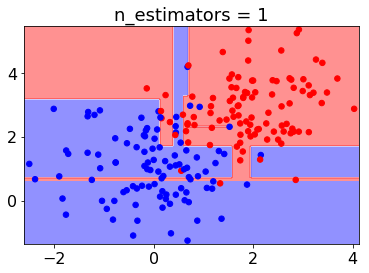

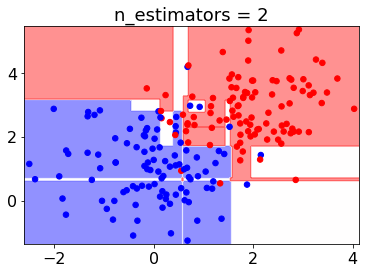

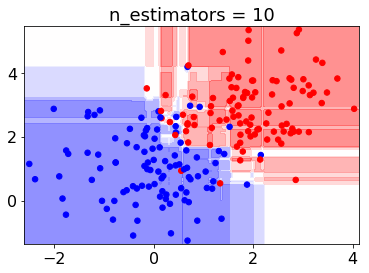

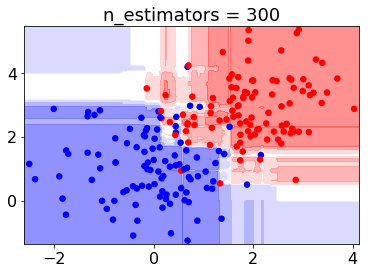

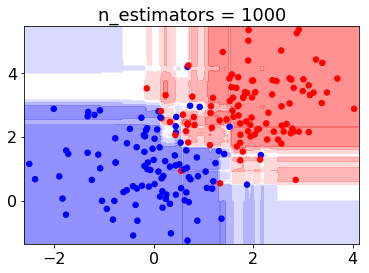

In [78]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
for n_trees in [1, 2, 10, 300,1000]:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=1).fit(X, y)
    plot_classifier_decision(rf, X, y)
    plt.title('n_estimators = {}'.format(n_trees))
    plt.show()

## Overfitting 

In [9]:
# defining toy datasets
toy_trainX, toy_trainY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=42, cluster_std=1.5)
toy_testX,  toy_testY  = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=3 , cluster_std=1.5)

# train random forest
rf = RandomForestClassifier(n_estimators=500).fit(toy_trainX, toy_trainY)

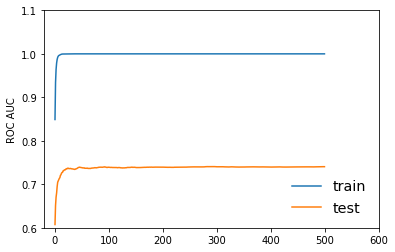

In [10]:
# compute the ROC AUC after adding one more estimator in the ensemble
for toyX, toyY, label in [(toy_trainX, toy_trainY, 'train'), (toy_testX, toy_testY, 'test')]:
    predictions = numpy.zeros(len(toyX))
    curve = []
    for tree in rf.estimators_:
        predictions += tree.predict(toyX)
        curve.append(roc_auc_score(toyY, predictions))
    
    plt.plot(curve,label=label)
    plt.ylim(0.6, 1.1)
    plt.xlim(-20,600)
    plt.ylabel('ROC AUC')
    plt.legend(frameon=False, fontsize='x-large', loc='best')

### Random Forest
- terribly simple
- has huge difference of the quality between predictions on train and validation sample
- it's quality never goes down with increasing the number of trees
- **never overfits**
    - huge difference between predictions on test and training does not imply the model is bad, RF is such model

## also...
- RF efficiently works with features of different scale and nature
- doesn't require (much) tuning 
- for large datasets may produce giant trees (which is long and takes lots of memory). <br />
  Makes sense to limit growth of trees (`max_depth` or `min_samples_leaf`)
- works well in many situations.

# Random forest for flight delay

In [11]:
rf = RandomForestClassifier(n_estimators=500).fit(trainX.to_pandas(), trainY)
print ('test', roc_auc_score(testY, rf.predict_proba(testX.to_pandas())[:, 1]))

test 0.628361138658


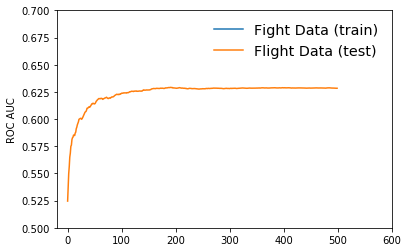

In [12]:
for sX, sY, label in [(trainX, trainY, 'Fight Data (train)'), (testX, testY, 'Flight Data (test)')]:
    predictions = numpy.zeros(len(sX))
    curve = []
    for tree in rf.estimators_:
        predictions += tree.predict(sX.to_pandas())
        curve.append(roc_auc_score(sY, predictions))
    
    plt.plot(curve,label=label)
    plt.ylim(0.5, 0.7)
    plt.xlim(-20,600)
    plt.ylabel('ROC AUC')
    plt.legend(frameon=False, fontsize='x-large', loc='best')

In [13]:
# look at the features importance
for feature, importance in zip(trainX.colnames, rf.feature_importances_):
    print (feature, importance)

MONTH 0.0600571319543
DAY 0.090811786529
DAY_OF_WEEK 0.0531757998232
AIRLINE_ID 0.0434950250193
FLIGHT_NUMBER_ID 0.114275735809
TAIL_NUMBER_ID 0.11845446655
ORIGIN_AIRPORT_ID 0.0884434599463
DESTINATION_AIRPORT_ID 0.090487918621
SCHEDULED_DEPARTURE 0.115918624958
DISTANCE 0.10717110215
SCHEDULED_ARRIVAL 0.117708948639


There are `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL` among the most important features.

# AdaBoost (Adaptive Boosting) 

AdaBoost operates by reweighting samples each time. Weight of sample is increased if base classifier makes a mistake. Formally, this corresponds to minimizing exponential loss function. Below, interface example to operate with AdaBoost in `sklearn`

In [91]:
from sklearn.ensemble    import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# define Ada Boost classifier over Decision Trees
ab_clf = AdaBoostClassifier(n_estimators=500, 
                            base_estimator=DecisionTreeClassifier(max_depth=5)).fit(trainX.to_pandas(), trainY)

# you can train AdaBoost over other classifiers
nb_clf = AdaBoostClassifier(n_estimators=500, base_estimator=GaussianNB()).fit(trainX.to_pandas(), trainY)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


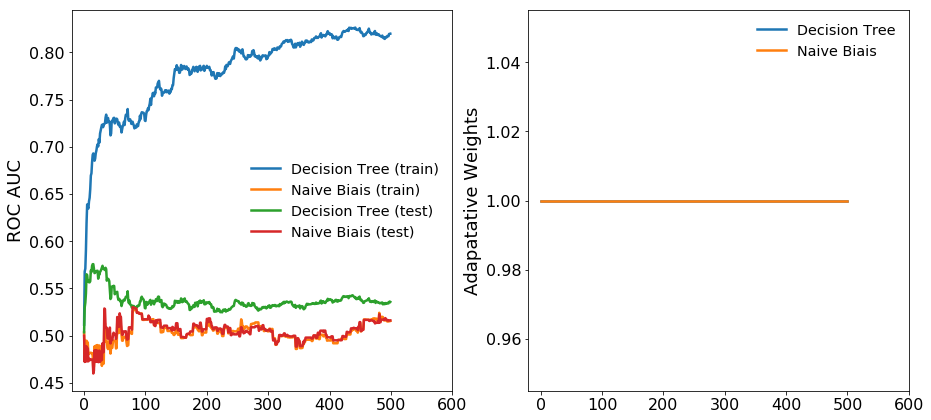

In [93]:
# Plot the area under the ROC curve for different Nestimator
plt.figure(figsize=(15,7))

for sX, sY, label in [(trainX, trainY, '(train)'), (testX, testY, '(test)')]:
    predictions = numpy.zeros(len(sX))
    weights_ab  = numpy.array( ab_clf.estimator_weights_ )
    weights_nb  = numpy.array( nb_clf.estimator_weights_ )
    curve_ab    = []
    curve_nb    = []
   
    i=0
    predictions=0
    for this_estimator in ab_clf.estimators_:
        predictions += weights_ab[i] * this_estimator.predict(sX.to_pandas())
        curve_ab.append( roc_auc_score(sY, predictions) )
        i=i+1           
        
    i=0
    predictions=numpy.zeros(len(sX))
    for this_estimator in nb_clf.estimators_:
        predictions += weights_nb[i] * this_estimator.predict(sX.to_pandas())
        curve_nb.append( roc_auc_score(sY, predictions) )
        i=i+1
    
    plt.subplot(121)
    plt.plot(curve_ab,label='Decision Tree '+label)
    plt.plot(curve_nb,label='Naive Biais '  +label)
    plt.xlim(-20,600)
    plt.ylabel('ROC AUC')
    plt.legend(frameon=False, fontsize='x-large', loc='best')
    
plt.subplot(122)
plt.plot(weights_ab,label='Decision Tree')
plt.plot(weights_nb,label='Naive Biais')
plt.xlim(-20,600)
plt.ylabel('Adapatative Weights')
plt.legend(frameon=False, fontsize='x-large', loc='best')

# Gradient Boosting (GB) demonstration

GBDT approximates target dependency by making steps in the space of functions:

* [GB explanation](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
* [GB classification playground](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)
    * play with it to understand the most important knobs and tricks of GB

AdaBoost is a particular case of Gradient Boosting.

GB = GBDT = GBRT = GBM = MART, these are names of same approach.

## Working with GB in sklearn

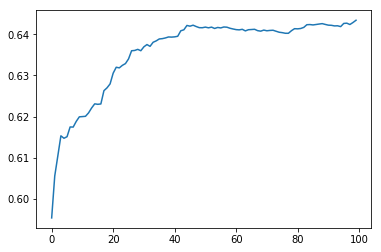

In [18]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
# define the Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
# fit the GB
gb_clf.fit(trainX.to_pandas(), trainY)

# compute qualtity, ROC AUC, after adding one more estimator into the ensemble
# use for this `staged_predict_proba` - iterator over predictions on each boosting iteration
test_qualities = []
for p in gb_clf.staged_predict_proba(testX.to_pandas()):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [16]:
roc_auc_score(testY, gb_clf.predict_proba(testX.to_pandas())[:, 1])

0.64345733214471623

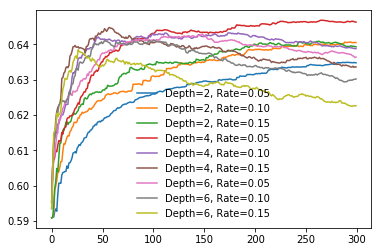

In [17]:
# trying a poor optimization
DepthRate = [(2,0.05),(2,0.1),(2,0.15),(4,0.05),(4,0.1),(4,0.15),(6,0.05),(6,0.1),(6,0.15)]

for Nd,Lr in DepthRate:
    # train
    gb_clf = GradientBoostingClassifier(n_estimators=300, learning_rate=Lr, max_depth=Nd, random_state=42)
    gb_clf.fit(trainX.to_pandas(), trainY)

    # compute predictions
    test_qualities  = []
    for p in gb_clf.staged_predict_proba(testX.to_pandas()):
        test_qualities.append(roc_auc_score(testY, p[:,1]))
    
    # plot results
    plt.plot(test_qualities ,label='Depth={:.0f}, Rate={:.2f}'.format(Nd,Lr))
    plt.legend(frameon=False, loc='best')

In [19]:
# print the best configuration
gb_clf_best = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4)
gb_clf_best.fit(trainX.to_pandas(), trainY)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [20]:
roc_auc_score(testY, gb_clf_best.predict_proba(testX.to_pandas())[:, 1])

0.64633660715167562

# XGBoost

It is another popular implementation of Gradient Boosting, which
- supports regularization
- uses hessian during optimization 
- supports sklearn interface
- works faster

In [22]:
from xgboost.sklearn import XGBClassifier
# define model as usual
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
# call fit as usual
xgb_clf.fit(trainX.to_pandas(), trainY)
# predict and compute roc auc
roc_auc_score(testY, xgb_clf.predict_proba(testX.to_pandas())[:, 1])

0.64551969503703577

In [14]:
create_solution(xgb_clf.predict_proba(test_kaggle.to_pandas())[:, 1], filename='flight-delay-xgb.csv')

/Users/axelr/Yandex.Disk.localized/2017-04-Heidelberg/practice/data/flight-delay-xgb.csv

# Categorical features preprocessing

trees can't efficiently use IDs, so we have several (combinable) options. <br />
Let's discuss those one-by-one


### 1) Replace category value by the respective count frequencies of this category in the column.

In [15]:
categorical_features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 
                        'AIRLINE_ID', 'FLIGHT_NUMBER_ID', 'TAIL_NUMBER_ID',
                        'ORIGIN_AIRPORT_ID', 'DESTINATION_AIRPORT_ID']

In [16]:
trainX_ext = trainX.copy()
testX_ext = testX.copy()

for feature in categorical_features:
    length = max(numpy.max(trainX_ext[feature]), numpy.max(testX_ext[feature])) + 1
    # compute frequency of each value in category
    counts = numpy.bincount(trainX_ext[feature], minlength=length)
    # add columns with frequencies
    trainX_ext[feature + '_freq'] = counts[trainX_ext[feature]]
    testX_ext[feature + '_freq']  = counts[testX_ext[feature]]
    
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
xgb_clf.fit(trainX_ext.to_pandas(), trainY)
print 'test', roc_auc_score(testY, xgb_clf.predict_proba(testX_ext.to_pandas())[:, 1])

test 0.651244719171


### 2) Replace category on probability that 1-class has this category value.

In [17]:
categorical_features = ['ORIGIN_AIRPORT_ID', 'DESTINATION_AIRPORT_ID']

In [18]:
trainX_ext = trainX.copy()
testX_ext = testX.copy()
    
for feature in categorical_features:
    length = max(numpy.max(trainX_ext[feature]), numpy.max(testX_ext[feature])) + 1
    counts = numpy.bincount(trainX_ext[feature], minlength=length)
    # compute mean response 
    probability_per_category = (numpy.bincount(trainX_ext[feature], 
                                               weights=trainY, minlength=length))  / (counts + 1)
    # avoid estimation for small categories
    probability_per_category[counts < 10] = numpy.mean(trainY)
    print feature, sum(counts > 10)
    # add column corresponds to P(Y=1|category value)
    trainX_ext[feature + '_mean'] = probability_per_category[trainX_ext[feature]]
    testX_ext[feature + '_mean']  = probability_per_category[testX_ext[feature]]
    
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
xgb_clf.fit(trainX_ext.to_pandas(), trainY)
print 'test', roc_auc_score(testY, xgb_clf.predict_proba(testX_ext.to_pandas())[:, 1])

ORIGIN_AIRPORT_ID 150
DESTINATION_AIRPORT_ID 140
test 0.634231715958


Add more samples into training to play with this approach (it is needed enough samples for each category to reliably estimate probability).

### 3) One-hot encoding

In [19]:
categorical_features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 
                        'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
                        'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
is_categorical = numpy.in1d(trainX.colnames, categorical_features)

In [20]:
encoder = OneHotEncoder(categorical_features=is_categorical, handle_unknown='ignore')
encoder.fit(trainX.to_pandas())
# prepare samples with one hot encoded categorical features
trainX_onehot = encoder.transform(trainX.to_pandas())
testX_onehot = encoder.transform(testX.to_pandas())

In [21]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
xgb_clf.fit(trainX_onehot, trainY)
print 'test', roc_auc_score(testY, xgb_clf.predict_proba(testX_onehot)[:, 1])

test 0.635173293866


# Catboost

[github](https://github.com/catboost/catboost), [arxiv](https://arxiv.org/abs/1706.09516)

In [ ]:
!pip install catboost

## What can you try to get better predictions for delays?

* increase number of trees in Random Forest, tune other parameters
* increase number of samples in training 
* tune gradient boosting (use [tutorial](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb))
* use more samples to provide better probabilities estimation in category preprocessing. Play with probabilities estimation (for instance, [add regularization](http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps))
* play with XGBoost parameters (especially with the depth in one-hot encoding approach!)
* engineer some better features
* your extra ideas are welcome!

# References

- [Introduction to boosted trees](https://xgboost.readthedocs.io/en/latest/model.html)
- Sklearn's [tutorial](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb) on tuning GBDT
- [Discussion](https://www.kaggle.com/c/caterpillar-tube-pricing/discussion/15748) on categorical features preprocessing
- [Paper on categorical features preprocessing](https://www.google.ru/url?sa=t&rct=j&q=&esrc=s&source=web&cd=22&ved=0ahUKEwiojrDiv43TAhVGGCwKHSm-Ccc4FBAWCCAwAQ&url=http%3A%2F%2Fhelios.mm.di.uoa.gr%2F~rouvas%2Fssi%2Fsigkdd%2Fsigkdd.vol3.1%2Fbarreca.ps&usg=AFQjCNEFLOpC3b3qzOSlpPMkIqOrtfL_Og&sig2=mCac7PX_oScJ43YIxjt5jw&bvm=bv.151426398,d.bGs&cad=rja)